# Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torchsom.core import TorchSOM
from torchsom.plotting import SOMVisualizer, VisualizationConfig

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing 

In [3]:
boston_df = pd.read_csv(
    filepath_or_buffer="../data/boston_housing.csv",
)

In [4]:
# boston_df_scaled = boston_df
scaler = StandardScaler()
boston_df_scaled = pd.DataFrame(scaler.fit_transform(boston_df), columns=boston_df.columns)

In [5]:
boston_df_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.159686
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101524
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.324247
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.487503


In [6]:
boston_df_scaled.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02,506.000000,5.060000e+02,5.060000e+02,5.060000e+02,5.060000e+02
mean,-1.123388e-16,7.898820e-17,2.106352e-16,-3.510587e-17,-1.965929e-16,-1.088282e-16,-1.474446e-16,-8.425408e-17,-1.123388e-16,0.000000,-4.212704e-16,-7.442444e-16,-3.089316e-16,-5.195668e-16
std,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00,1.000990,1.000990e+00,1.000990e+00,1.000990e+00,1.000990e+00
min,-4.197819e-01,-4.877224e-01,-1.557842e+00,-2.725986e-01,-1.465882e+00,-3.880249e+00,-2.335437e+00,-1.267069e+00,-9.828429e-01,-1.313990,-2.707379e+00,-3.907193e+00,-1.531127e+00,-1.908226e+00
25%,-4.109696e-01,-4.877224e-01,-8.676906e-01,-2.725986e-01,-9.130288e-01,-5.686303e-01,-8.374480e-01,-8.056878e-01,-6.379618e-01,-0.767576,-4.880391e-01,2.050715e-01,-7.994200e-01,-5.994557e-01
50%,-3.906665e-01,-4.877224e-01,-2.110985e-01,-2.725986e-01,-1.442174e-01,-1.084655e-01,3.173816e-01,-2.793234e-01,-5.230014e-01,-0.464673,2.748590e-01,3.811865e-01,-1.812536e-01,-1.450593e-01
75%,7.396560e-03,4.877224e-02,1.015999e+00,-2.725986e-01,5.986790e-01,4.827678e-01,9.067981e-01,6.623709e-01,1.661245e+00,1.530926,8.065758e-01,4.336510e-01,6.030188e-01,2.685231e-01
max,9.933931e+00,3.804234e+00,2.422565e+00,3.668398e+00,2.732346e+00,3.555044e+00,1.117494e+00,3.960518e+00,1.661245e+00,1.798194,1.638828e+00,4.410519e-01,3.548771e+00,2.989460e+00


In [7]:
feature_names = boston_df_scaled.columns.to_list()[:-1]
feature_names

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [8]:
boston_df_scaled.shape

(506, 14)

In [9]:
"""
1. Create a tensor from the boston df and separate the features and the target
2. Randomly shuffle the data
3. Split the data into training and testing sets
"""
boston_torch = torch.tensor(boston_df_scaled.to_numpy(dtype=np.float32))
all_features, all_targets = boston_torch[:, :-1], boston_torch[:, -1]


shuffled_indices = torch.randperm(len(all_features))
all_features, all_targets = all_features[shuffled_indices], all_targets[shuffled_indices]

train_ratio = 0.8
train_count = int(train_ratio * len(all_features))
train_features, train_targets = all_features[:train_count], all_targets[:train_count]
test_features, test_targets = all_features[train_count:], all_targets[train_count:]

print(train_features.shape, test_features.shape)
print(train_targets.shape, test_targets.shape)

torch.Size([404, 13]) torch.Size([102, 13])
torch.Size([404]) torch.Size([102])


# TorchSOM

In [10]:
som = TorchSOM(
    x=50,
    y=30,
    sigma=2.3,
    learning_rate=0.95,
    neighborhood_order=3,
    epochs=125,
    batch_size=16,
    topology="rectangular",
    distance_function="euclidean",
    neighborhood_function="gaussian",
    num_features=all_features.shape[1],
    lr_decay_function="asymptotic_decay",
    sigma_decay_function="asymptotic_decay",
    initialization_mode="pca",
    device=device,
    random_seed=random_seed,
) 

In [11]:
som.initialize_weights(
    data=train_features,
)

In [12]:
QE, TE = som.fit(
    data=train_features
)

Training SOM: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 12.36epoch/s]


In [13]:
visualizer = SOMVisualizer(som=som, config=None)
save_path = "results/boston" # Set to None if you want a direct plot

In [14]:
visualizer.plot_training_errors(
    quantization_errors=QE, 
    topographic_errors=TE, 
    save_path=save_path
)

In [15]:
visualizer.plot_distance_map(save_path=save_path)

In [16]:
visualizer.plot_hit_map(
    data=train_features,
    save_path=save_path
)

In [17]:
visualizer.plot_metric_map(
    data=train_features,
    target=train_targets,
    reduction_parameter="mean",
    save_path=save_path,
)

In [18]:
visualizer.plot_metric_map(
    data=train_features,
    target=train_targets,
    reduction_parameter="std",
    save_path=save_path,
)

In [19]:
visualizer.plot_rank_map(
    data=train_features,
    target=train_targets,
    save_path=save_path
)

In [20]:
visualizer.plot_score_map(
    data=train_features,
    target=train_targets,
    save_path=save_path,
)

In [21]:
visualizer.plot_component_planes(
    component_names=feature_names,
    save_path=save_path
)

# Prediction
Here, we do not add the testing samples in the SOM BMUs map.  
In forecasting or process control, it is interesting to add overtime the new elements in the SOM and potentially to update/refit it with a certain frequency.

In [22]:
predictions = []
bmus_idx_map = som.build_bmus_data_map(
    data=train_features,
    return_indices=True,  # False means we want the features of each sample and not the indices
)
for idx, (test_feature, test_target) in enumerate(zip(test_features, test_targets)):
        
    collected_features, collected_targets = som.collect_samples(
        query_sample=test_feature,
        historical_samples=train_features,
        historical_outputs=train_targets,
        min_buffer_threshold=125, # Collect 30 historical samples to train a model
        bmus_idx_map=bmus_idx_map,
    )
    
    X = collected_features.cpu().numpy()
    y = collected_targets.cpu().numpy().ravel()
    test_feature_np = test_feature.cpu().numpy().reshape(1, -1)  
    
    reg = MLPRegressor(
        hidden_layer_sizes=(8, 16, 16, 8),
        max_iter=250,
        learning_rate_init=0.005,
        activation="relu",
        solver="adam",
        batch_size='auto', 
        random_state=random_seed,
        shuffle=True,
        verbose=False,
    ).fit(X, y)
    
    # plt.plot(reg.loss_curve_)
    # plt.xlabel("Iteration")
    # plt.ylabel("Loss")
    # plt.title("MLPRegressor Training Loss Curve")
    # plt.grid(True)
    # plt.show()
    
    reg_prediction = reg.predict(test_feature_np)
    predictions.append(reg_prediction[0]) 

In [23]:
y_pred = np.array(predictions)
y_true = test_targets.numpy()     

mae = mean_absolute_error(y_true, y_pred) 
mse = mean_squared_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.2f}")

MAE: 0.2574
MSE: 0.1785
RMSE: 0.4225
R2: 0.84


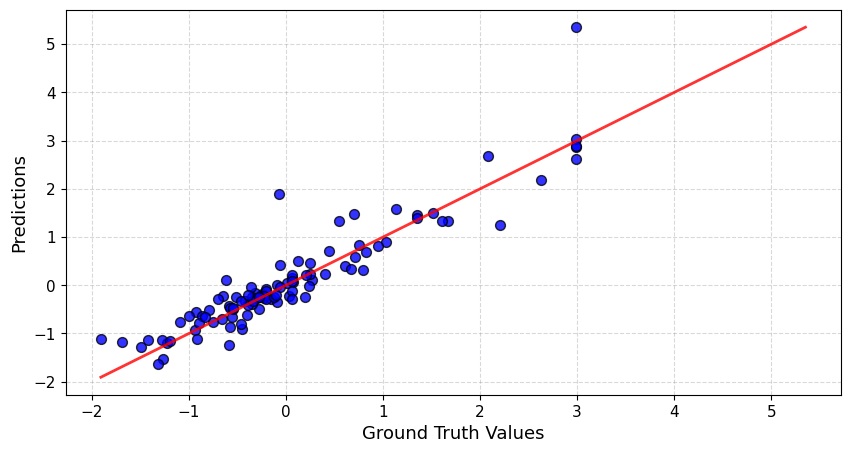

In [24]:
min_val = min(min(y_pred), min(y_true))
max_val = max(max(y_pred), max(y_true))

plt.figure(figsize=(10, 5))
plt.scatter(
    y_true, 
    y_pred, 
    alpha=0.8,
    color="blue",
    marker="o",
    edgecolor="black",
    s=50,
    label="Predictions",
)
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    label="Perfect Prediction",
    color="red",
    alpha=0.8,
    linewidth=2
)
plt.xlabel("Ground Truth Values")
plt.ylabel("Predictions")
plt.show()